## Coursera IBM Data Science Capstone Project
### Battle of the Neighborhoods
*Author: Luis Castillo*  
*January, 2019*

#### Contents
1. [Introduction / Business Problem](#introduction)
2. [Data Preparation](#data-prep)  
    2.1. [Madrid Location Data](#id-2-1)  
    2.2. [Valencia Location Data](#id-2-2)  
    2.3. [Madrid Population Data](#id-2-3)  
    2.4. [Madrid Income Data](#id-2-4)  
    2.5. [Combined neighborhood](#id-2-3)  
3. [Methodology](#methodology)  
    3.1. [Madrid Neighborhoods Visualization](#id-3-1)  
    3.2. [Explore Madrid Neighborhoods using the Foursquare API](#id-3-2)  
    3.3. [Clustering Madrid and val neighborhoods](#id-3-3)  
    3.4. [Neighborhood Ranking](#id-3-4)
4. [Results Summary](#results)



## 1. Introduction / Business Problem <a id='introduction'></a>
This notebook corresponds to the final assignment of the Coursera *Applied Data Science Capstone* course, which is the final step for the *IBM Data Science Professional Certificate* specialization. The final capstone project consists on applying the methodologies learned during the specialization to solve a fictional business problem, ensuring that the Foursquare API data is used in part of the analysis.  

For this project, I selected to work with selecting a suitable location for a fictional restaurant in Madrid city. Below is the business problem description:  

Our customer, the restaurant chain “XYZ Fancy Dining” is interested in opening a new restaurant in Madrid. Madrid is one of the busiest cities in Europe, with more than three million residents and an average of almost 800.000 visitors each month.
This would be our customer’s second restaurant location, after having successfully opened a venue in Greenwich Village, a very lively neighborhood from Valencia city.   
Considering that our customer has had very good results with their val location, they have requested our data science team to find a neighborhood with similar characteristics.  
The problem question would be: **What neighborhood from Madrid has the most similar characteristics in terms of entertainment and dining options compared to El Carme in Valencia City?**  

The data to be used for this project comes from three different locations:  
* Foursquare. It is a local search-and-discovery service which provides information on different types of entertainment, drinking and dining venues. Foursquare has an API that can be used to query their database and find information related to the venues, such as location, overall category, reviews and tips.  
* Madrid Neighborhood Names and geographic coordinates. Available on https://datos.madrid.es/, this is used to obtain the neighborhood location information from the city.  
* Valencia City Neighborhood Names and geographic coordinates. Data available on http://mapas.valencia.es/lanzadera/opendata/Barrios/SHAPE



## 2. Data Preparation<a id='data-prep'></a>


On this section, we will consolidate the data from our three data sources into a new dataset we will use for the clustering process. First step is to process the Madrid Neighborhood data, which is available in a .shp file.  

We will first import all libraries to be used on this section, and then proceed with the data wrangling.

In [581]:
# Import required python libraries
import pandas as pd
import geopandas as gpd # The geopandas library allows working with geospatial data easily. See http://geopandas.org/
import numpy as np
import folium
import requests
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

### **2.1 Madrid Location Data** <a id='id-2-1'></a>


In [582]:
#Import Neighborhoods geodata
madrid_neighborhoods = gpd.read_file("data/neighborhoods-madrid/BARRIOS.shp")

Lets get some basic information on the imported data

In [583]:
madrid_neighborhoods.head(3)

,OBJECTID,geodb_oid,CODDIS,NOMDIS,CODBAR,CODDISTRIT,CODBARRIO,NOMBRE,ORIG_FID,geometry
0,108,108,17,Villaverde,172,17,17-2,San Cristobal,107,"POLYGON ((441930.8668000005 4466853.1887, 4419..."
1,109,109,17,Villaverde,173,17,17-3,Butarque,108,"POLYGON ((444144.8566044134 4464473.210504748,..."
2,111,111,17,Villaverde,175,17,17-5,Los Angeles,110,"POLYGON ((441147.7280000008 4466374.483400001,..."


In [584]:
madrid_neighborhoods.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 131 entries, 0 to 130
Data columns (total 10 columns):
OBJECTID      131 non-null int64
geodb_oid     131 non-null int64
CODDIS        131 non-null object
NOMDIS        131 non-null object
CODBAR        131 non-null object
CODDISTRIT    131 non-null object
CODBARRIO     131 non-null object
NOMBRE        131 non-null object
ORIG_FID      131 non-null int64
geometry      131 non-null object
dtypes: int64(3), object(7)
memory usage: 10.3+ KB


In [585]:
#Check what is projection (Folium uses WSGS84, epsg=4326)
madrid_neighborhoods.crs

{'init': 'epsg:25830'}

We can make some observations on the data source:  
* As expected, all field names are in spanish, we will translate this to english.
* The data source contains a "geometry" column which basically contains a polygon delimiting each neighborhood. We actually only need the coordinates of a point for each neighborhood, so we will need to obtain the center coordinates of each polygon (centroid), thankfully Geopandas can help us with that.
* The coordinate system is not WGS84. To ensure compatibility with other data sources, we will need to translate to WGS84. Geopandas has a method to do this easily

In [586]:
#Since Projection is not WGS84, use geopandas to_crs method to convert:
madrid_neighborhoods =  madrid_neighborhoods.to_crs(epsg='4326')
madrid_neighborhoods.crs

{'init': 'epsg:4326', 'no_defs': True}

In [587]:
#Add Longitude/Latitutde coordinates using the centroid
madrid_neighborhoods['Longitude'] = madrid_neighborhoods.centroid.x
madrid_neighborhoods['Latitude'] = madrid_neighborhoods.centroid.y

In [588]:
#Remove unnecessary columns, translate column names to english
madrid_neighborhoods = madrid_neighborhoods[['NOMDIS','NOMBRE','geometry','Longitude','Latitude']]
madrid_neighborhoods.rename(columns={'NOMDIS':'District',
                                     'NOMBRE':'Neighborhood'}, inplace=True)

In [589]:
#Check the dataset
madrid_neighborhoods.head(3)

,District,Neighborhood,geometry,Longitude,Latitude
0,Villaverde,San Cristobal,POLYGON ((-3.683790913754153 40.35021495613195...,-3.688372,40.340888
1,Villaverde,Butarque,POLYGON ((-3.657513637252129 40.32892568402512...,-3.676254,40.337115
2,Villaverde,Los Angeles,POLYGON ((-3.692967961823778 40.34584760766253...,-3.699137,40.355790


In [590]:
#Drop the Geometry column, we will not use it anymore
madrid_neighborhoods.drop(columns=['geometry'], axis=1, inplace=True)

In [591]:
#Add city Name (Will be used later)
madrid_neighborhoods['City']='Madrid'

In [592]:
#Convert geopandas dataframe to Pandas dataframe
madrid_neighborhoods = pd.DataFrame(madrid_neighborhoods)
print(type(madrid_neighborhoods))

<class 'pandas.core.frame.DataFrame'>


In [593]:
madrid_neighborhoods.iloc[19]

District        Puente de Vallecas
Neighborhood             Entrevías
Longitude                 -3.67311
Latitude                   40.3748
City                        Madrid
Name: 19, dtype: object

In [594]:
#Remove special spanish characters (investigate how to do this more efficiently)
madrid_neighborhoods['Neighborhood'] = madrid_neighborhoods['Neighborhood'].str.replace(u"á","a")
madrid_neighborhoods['Neighborhood'] = madrid_neighborhoods['Neighborhood'].str.replace(u"é","e")
madrid_neighborhoods['Neighborhood'] = madrid_neighborhoods['Neighborhood'].str.replace(u"í","i")
madrid_neighborhoods['Neighborhood'] = madrid_neighborhoods['Neighborhood'].str.replace(u"ó","o")
madrid_neighborhoods['Neighborhood'] = madrid_neighborhoods['Neighborhood'].str.replace(u"ú","u")
#madrid_neighborhoods['Neighborhood'] = madrid_neighborhoods['Neighborhood'].str.replace(u"ñ","n")
#madrid_neighborhoods['Neighborhood'] = madrid_neighborhoods['Neighborhood'].str.replace(u"Ñ","N")

In [595]:
#Set District and Neighborhood to uppercase
madrid_neighborhoods['District'] = madrid_neighborhoods['District'].str.upper()
madrid_neighborhoods['Neighborhood'] = madrid_neighborhoods['Neighborhood'].str.upper()

In [596]:
#Check the dataset
madrid_neighborhoods.head(3)

,District,Neighborhood,Longitude,Latitude,City
0,VILLAVERDE,SAN CRISTOBAL,-3.688372,40.340888,Madrid
1,VILLAVERDE,BUTARQUE,-3.676254,40.337115,Madrid
2,VILLAVERDE,LOS ANGELES,-3.699137,40.355790,Madrid


In [597]:
print('The number of neighborhoods in Madrid is: {}'.format(madrid_neighborhoods['Neighborhood'].nunique()))
print('The number of districts in Madrid is: {}'.format(madrid_neighborhoods['District'].nunique()))

The number of neighborhoods in Madrid is: 131
The number of districts in Madrid is: 21


### **2.2 Valencia Location Data**<a id='id-2-2'></a>

In [598]:
# Import neighborhoods
val_neighborhoods = gpd.read_file("http://mapas.valencia.es/lanzadera/opendata/Barrios/SHAPE")

Lets get some basic information on the imported data

In [599]:
val_neighborhoods.head(3)

,codbarrio,nombre,coddistbar,coddistrit,geometry
0,1,BENIFARAIG,171,17,"POLYGON ((725499.03 4378693.39, 725477.797 437..."
1,1,BENICALAP,161,16,"POLYGON ((725164.733 4375392.58, 725187.044 43..."
2,2,TORREFIEL,152,15,"POLYGON ((726040.348 4375385.446, 725995.041 4..."


In [600]:
val_neighborhoods.info()

<class 'geopandas.geodataframe.GeoDataFrame'>
RangeIndex: 88 entries, 0 to 87
Data columns (total 5 columns):
codbarrio     88 non-null object
nombre        88 non-null object
coddistbar    88 non-null object
coddistrit    88 non-null object
geometry      88 non-null object
dtypes: object(5)
memory usage: 3.5+ KB


In [601]:
val_neighborhoods.crs

{'init': 'epsg:25830'}

We can make some observations on the data source:  
* As expected, the field names are different than the Madrid dataset. We will need to readjust for it to be the same.
* The data source contains a "point" column which contains the coordinates for each neighborhood. We should extract the Latitude/Longitude from this column
* The coordinate system is not WGS84 (epsg = 4326). To ensure compatibility with other data sources, we will need to translate to WGS84. Geopandas has a method to do this easily

In [602]:
#Since Projection is not WGS84, use geopandas to_crs method to convert:
val_neighborhoods =  val_neighborhoods.to_crs(epsg='4326')
val_neighborhoods.crs

{'init': 'epsg:4326', 'no_defs': True}

In [603]:
#Add Longitude/Latitutde coordinates using the centroid
val_neighborhoods['Longitude'] = val_neighborhoods.centroid.x
val_neighborhoods['Latitude'] = val_neighborhoods.centroid.y

In [604]:
#Remove unnecessary columns, translate column names to english
val_neighborhoods = val_neighborhoods[['nombre','coddistrit','geometry','Longitude','Latitude']]
val_neighborhoods.rename(columns={'coddistrit':'District',
                                  'nombre':'Neighborhood'}, inplace=True)

In [605]:
#Drop the Geometry column, we will not use it anymore
val_neighborhoods.drop(columns=['geometry'], axis=1, inplace=True)

In [606]:
#Reorganize columns
val_neighborhoods = val_neighborhoods[['District','Neighborhood','Longitude','Latitude']]

In [607]:
#Add city Name
val_neighborhoods['City']='Valencia'

In [608]:
#Convert geopandas dataframe to Pandas dataframe
val_neighborhoods = pd.DataFrame(val_neighborhoods)
print(type(val_neighborhoods))

<class 'pandas.core.frame.DataFrame'>


In [609]:
#Check the dataset
val_neighborhoods.head(3)

,District,Neighborhood,Longitude,Latitude,City
0,17,BENIFARAIG,-0.384621,39.525644,Valencia
1,16,BENICALAP,-0.391002,39.493006,Valencia
2,15,TORREFIEL,-0.376932,39.495198,Valencia


In [610]:
print('The number of neighborhoods in Valencia is: {}'.format(val_neighborhoods['Neighborhood'].nunique()))
print('The number of districts in Valencia is: {}'.format(val_neighborhoods['District'].nunique()))

The number of neighborhoods in Valencia is: 88
The number of districts in Valencia is: 19


### 2.3 Madrid Population <a id='id-2-3'></a>
In this part, we will create a dataset with the population per neighborhood.
The data source for this dataset was downloaded from the Madrid databank, see: http://www-2.madrid.es/CSE6/control/menuCSE?filtro=NS&tablaSerie=SERIES

In [611]:
madrid_population = pd.read_excel('data/population-madrid/population-madrid.xls', skipfooter=4, skiprows=4)
madrid_population.head()

,Distrito,Barrio,Edad,Total
0,CENTRO,PALACIO,Total,22984
1,CENTRO,EMBAJADORES,Total,45433
2,CENTRO,CORTES,Total,10525
3,CENTRO,JUSTICIA,Total,17205
4,CENTRO,UNIVERSIDAD,Total,31809


In [612]:
madrid_population.drop('Edad', axis=1, inplace=True)
madrid_population.columns = ['District','Neighborhood','Population']

In [613]:
#Check if by merging with madrid dataset we get the same amount of neighborhoods
madrid_population.merge(madrid_neighborhoods, on='Neighborhood', how='inner').shape

(119, 7)

There are 131 neighborhoods in the Madrid dataset, however when matching with the population dataset (different source) we don't get a match for all the neighborhoods. Lets investigate which are different

In [614]:
#Outer Join
test = madrid_population.merge(madrid_neighborhoods, on='Neighborhood', how='outer')
test[test.isnull().any(axis=1)]

,District_x,Neighborhood,Population,District_y,Longitude,Latitude,City
17,RETIRO,LOS JERONIMOS,7069.0,NaN,NaN,NaN,NaN
44,FUENCARRAL-EL PARDO,FUENTELARREINA,3272.0,NaN,NaN,NaN,NaN
45,FUENCARRAL-EL PARDO,PEÑA GRANDE,44621.0,NaN,NaN,NaN,NaN
46,FUENCARRAL-EL PARDO,EL PILAR,46577.0,NaN,NaN,NaN,NaN
52,MONCLOA-ARAVACA,ARGUELLES,24191.0,NaN,NaN,NaN,NaN
58,LATINA,LOS CARMENES,17448.0,NaN,NaN,NaN,NaN
64,LATINA,LAS AGUILAS,51703.0,NaN,NaN,NaN,NaN
106,VILLAVERDE,VILLAVERDE ALTO C.H.,45324.0,NaN,NaN,NaN,NaN
111,VILLA DE VALLECAS,CASCO H.VALLECAS,40352.0,NaN,NaN,NaN,NaN
114,VICALVARO,CASCO H.VICALVARO,34928.0,NaN,NaN,NaN,NaN


In [615]:
#Update column names to match both dataframes
madrid_neighborhoods.loc[madrid_neighborhoods['Neighborhood'] == 'JERONIMOS', 'Neighborhood'] = 'LOS JERONIMOS'
madrid_neighborhoods.loc[madrid_neighborhoods['Neighborhood'] == 'FUENTELAREINA', 'Neighborhood'] = 'FUENTELARREINA'
madrid_neighborhoods.loc[madrid_neighborhoods['Neighborhood'] == 'PEÑAGRANDE', 'Neighborhood'] = 'PEÑA GRANDE'
madrid_neighborhoods.loc[madrid_neighborhoods['Neighborhood'] == 'PILAR', 'Neighborhood'] = 'EL PILAR'
madrid_neighborhoods.loc[madrid_neighborhoods['Neighborhood'] == 'ARGÜELLES', 'Neighborhood'] = 'ARGUELLES'
madrid_neighborhoods.loc[madrid_neighborhoods['Neighborhood'] == 'CARMENES', 'Neighborhood'] = 'LOS CARMENES'
madrid_neighborhoods.loc[madrid_neighborhoods['Neighborhood'] == 'AGUILAS', 'Neighborhood'] = 'LAS AGUILAS'
madrid_neighborhoods.loc[madrid_neighborhoods['Neighborhood'] == 'VILLAVERDE ALTO, CASCO HISTORICO DE VILLAVERDE', 'Neighborhood'] = 'VILLAVERDE ALTO C.H.'
madrid_neighborhoods.loc[madrid_neighborhoods['Neighborhood'] == 'CASCO HISTORICO DE VALLECAS', 'Neighborhood'] = 'CASCO H.VALLECAS'
madrid_neighborhoods.loc[madrid_neighborhoods['Neighborhood'] == 'CASCO HISTORICO DE VICALVARO', 'Neighborhood'] = 'CASCO H.VICALVARO'
madrid_neighborhoods.loc[madrid_neighborhoods['Neighborhood'] == 'SALVADOR', 'Neighborhood'] = 'EL SALVADOR'
madrid_neighborhoods.loc[madrid_neighborhoods['Neighborhood'] == 'CASCO HISTORICO DE BARAJAS', 'Neighborhood'] = 'CASCO H.BARAJAS'

In [616]:
#Check if by merging with madrid dataset we get the same amount of neighborhoods
madrid_population.merge(madrid_neighborhoods, on='Neighborhood').shape

(131, 7)

Now both dataframes match! We will use the madrid_population dataset later

### 2.4 Average Income per neighborhood dataset <a id='id-2-4'></a>
This dataset contains the average income per neighborhood in madrid. Source file available on this link:
https://www.madrid.es/UnidadesDescentralizadas/UDCEstadistica/Nuevaweb/Econom%C3%ADa/Renta/Urban%20Audit/D3300118.xls  
The file was pre-processed in Excel

In [686]:
madrid_income = pd.read_excel('data/income-madrid/income-madrid.xls')
madrid_income.head()

,District,Neighborhood,Average Income
0,CENTRO,PALACIO,34675.85
1,CENTRO,EMBAJADORES,25999.83
2,CENTRO,CORTES,34952.68
3,CENTRO,JUSTICIA,40314.88
4,CENTRO,UNIVERSIDAD,30701.65


In [688]:
#Check if by merging with madrid dataset we get the same amount of neighborhoods
madrid_income.merge(madrid_neighborhoods, on='Neighborhood', how='inner').shape

(131, 7)

We have 131 neighborhoods, good to go!

We will use the madrid_income dataset later

### 2.5 Neighborhoods dataset <a id='id-2-5'></a>
In this part, we will simply create a new dataset combining both Madrid and val neighborhood lists. This will be used later for clustering

In [617]:
#Concatenate two dataframes
neighborhoods = pd.concat([madrid_neighborhoods,val_neighborhoods])

In [618]:
#Check random neighborhoods Madrid
neighborhoods[neighborhoods['City']=='Madrid'].head(3)

,District,Neighborhood,Longitude,Latitude,City
0,VILLAVERDE,SAN CRISTOBAL,-3.688372,40.340888,Madrid
1,VILLAVERDE,BUTARQUE,-3.676254,40.337115,Madrid
2,VILLAVERDE,LOS ANGELES,-3.699137,40.355790,Madrid


In [619]:
#Check random neighborhoods Valencia
neighborhoods[neighborhoods['City']=='Valencia'].head(3)

,District,Neighborhood,Longitude,Latitude,City
0,17,BENIFARAIG,-0.384621,39.525644,Valencia
1,16,BENICALAP,-0.391002,39.493006,Valencia
2,15,TORREFIEL,-0.376932,39.495198,Valencia


In [620]:
#Count number of neighborhoods per city
neighborhoods.groupby('City')['Neighborhood'].count()

City
Madrid      131
Valencia     88
Name: Neighborhood, dtype: int64

## 3. Methodology<a id='methodology'></a>

### 3.1. Madrid Neighborhoods Visualization <a id='id-3-1'></a>

In [621]:
#Obtain the coordinates from the dataset itself, just averaging Latitude/Longitude of the current dataset 
lat_madrid = madrid_neighborhoods['Latitude'].mean()
lon_madrid = madrid_neighborhoods['Longitude'].mean()
print('The geographical coordinates of Madrid are {}, {}'.format(lat_madrid, lon_madrid))

The geographical coordinates of Madrid are 40.42384071409435, -3.680098265322107


In [622]:
# Create a list of districts, to be used later
districts = madrid_neighborhoods['District'].unique().tolist()

In [623]:
# This code is to create a dictionary to map a random color to each borough. 
# https://stackoverflow.com/questions/28999287/generate-random-colors-rgb/28999469 and 
# https://stackoverflow.com/questions/3380726/converting-a-rgb-color-tuple-to-a-six-digit-code-in-python
district_color = {}
for district in districts:
    district_color[district]= '#%02X%02X%02X' % tuple(np.random.choice(range(256), size=3)) #Random color

In [624]:
# create map of Madrid using latitude and longitude values
map_madrid = folium.Map(location=[lat_madrid, lon_madrid], zoom_start=11, control_scale=True)

# add markers to map
for lat, lng, district, neighborhood in zip(madrid_neighborhoods['Latitude'], 
                                            madrid_neighborhoods['Longitude'],
                                            madrid_neighborhoods['District'], 
                                            madrid_neighborhoods['Neighborhood']):
    label_text = district + ' - ' + neighborhood
    label = folium.Popup(label_text, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        tooltip = label_text,
        radius=4,
        popup=label,
        color=district_color[district],
        fill=True,
        fill_color=district_color[district],
        fill_opacity=0.7).add_to(map_madrid)  
    
map_madrid

### 3.2. Explore Madrid and val Neighborhoods using the Foursquare API <a id="id-3-2"></a>

In [625]:
CLIENT_ID = 'TWOZ1RBXJLFNVXN1GCNRMXVTI3YQR5UWQIIKU1NB11VBQNAL' # your Foursquare ID
CLIENT_SECRET = 'FKR5PXODGZ52EQH3PDEGCCERQLFRHZUPP2Q2MHF2MBHU41IE' # your Foursquare Secret
VERSION = '20180605' # Foursquare API version
LIMIT = 200 # limit of number of venues returned by Foursquare API
radius = 500 # define radius

Borrowing the function we used in the course lab (getNearbyVenues), and modifying it by adding the City and District Name

In [626]:
def getNearbyVenues(names, districts, cities, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, district, city, lat, lng in zip(names, districts, cities, latitudes, longitudes):
        print('Processing City: {}, District: {}, Neighborhood: {}'.format(city, district, name))
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            district,
            city,
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood',
                             'District',
                             'City',
                             'Neighborhood Latitude', 
                             'Neighborhood Longitude', 
                             'Venue', 
                             'Venue Latitude', 
                             'Venue Longitude', 
                             'Venue Category']
    
    return(nearby_venues)

In [627]:
venues = getNearbyVenues(names=neighborhoods['Neighborhood'],
                         districts = neighborhoods['District'],
                         cities = neighborhoods['City'],
                         latitudes=neighborhoods['Latitude'],
                         longitudes=neighborhoods['Longitude'])

Processing City: Madrid, District: VILLAVERDE, Neighborhood: SAN CRISTOBAL
Processing City: Madrid, District: VILLAVERDE, Neighborhood: BUTARQUE
Processing City: Madrid, District: VILLAVERDE, Neighborhood: LOS ANGELES
Processing City: Madrid, District: VILLAVERDE, Neighborhood: LOS ROSALES
Processing City: Madrid, District: VILLAVERDE, Neighborhood: VILLAVERDE ALTO C.H.
Processing City: Madrid, District: USERA, Neighborhood: ORCASITAS
Processing City: Madrid, District: VILLA DE VALLECAS, Neighborhood: ENSANCHE DE VALLECAS
Processing City: Madrid, District: CARABANCHEL, Neighborhood: BUENAVISTA
Processing City: Madrid, District: LATINA, Neighborhood: CUATRO VIENTOS
Processing City: Madrid, District: USERA, Neighborhood: SAN FERMIN
Processing City: Madrid, District: VILLA DE VALLECAS, Neighborhood: CASCO H.VALLECAS
Processing City: Madrid, District: USERA, Neighborhood: ORCASUR
Processing City: Madrid, District: USERA, Neighborhood: ZOFIO
Processing City: Madrid, District: USERA, Neighbo

In [628]:
#Get how many venues were found
print('A total of {} venues were found in Madrid'.format(venues[venues['City']=='Madrid'].shape[0]))
print('A total of {} venues were found in Valencia'.format(venues[venues['City']=='Valencia'].shape[0]))

A total of 3517 venues were found in Madrid
A total of 2552 venues were found in Valencia


In [629]:
#Show the new dataset
venues.head()

,Neighborhood,District,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,SAN CRISTOBAL,VILLAVERDE,Madrid,40.340888,-3.688372,Cercanías San Cristóbal de Los Ángeles,40.341710,-3.683878,Train Station
1,SAN CRISTOBAL,VILLAVERDE,Madrid,40.340888,-3.688372,Igreen Aire Acondicionado y Climatización,40.341581,-3.686213,Furniture / Home Store
2,SAN CRISTOBAL,VILLAVERDE,Madrid,40.340888,-3.688372,Bar Vietnam,40.341090,-3.686568,Snack Place
3,SAN CRISTOBAL,VILLAVERDE,Madrid,40.340888,-3.688372,El Rincón de Peri,40.342427,-3.691998,Breakfast Spot
4,BUTARQUE,VILLAVERDE,Madrid,40.337115,-3.676254,Mercadona,40.340165,-3.675179,Grocery Store


In [630]:
# Count the number of locations per Venue Category in Madrid
venues[venues['City']=='Madrid'].groupby('Venue Category').count()['Neighborhood'].sort_values(ascending=False).head(10)

Venue Category
Spanish Restaurant    381
Restaurant            193
Bar                   166
Tapas Restaurant      154
Café                  109
Hotel                 100
Coffee Shop            91
Bakery                 84
Pizza Place            74
Italian Restaurant     73
Name: Neighborhood, dtype: int64

In [631]:
# Count the number of locations per Venue Category in Valencia
venues[venues['City']=='Valencia'].groupby('Venue Category').count()['Neighborhood'].sort_values(ascending=False).head(10)

Venue Category
Spanish Restaurant          178
Tapas Restaurant            153
Restaurant                  113
Mediterranean Restaurant    103
Café                         87
Hotel                        85
Grocery Store                83
Italian Restaurant           80
Bakery                       65
Coffee Shop                  59
Name: Neighborhood, dtype: int64

In [632]:
#Number of unique venue categories per city
print('There are {} uniques categories in Madrid.'.format(len(venues[venues['City']=='Madrid']['Venue Category'].unique())))
print('There are {} uniques categories in Valencia.'.format(len(venues[venues['City']=='Valencia']['Venue Category'].unique())))

There are 269 uniques categories in Madrid.
There are 214 uniques categories in Valencia.


In [633]:
#Obtain the number of venues per neighborhood
venues_count = venues.groupby(['City','District','Neighborhood'])['District'].count().to_frame()
venues_count.head(3)

District
City   District   Neighborhood          
Madrid ARGANZUELA ACACIAS             50
                  ATOCHA              32
                  CHOPERA             44

In [634]:
#Fix title and remove multiindex
venues_count.rename(columns={'District':'N_venues'}, inplace=True)
venues_count.reset_index(inplace=True)
venues_count.head(3)

,City,District,Neighborhood,N_venues
0,Madrid,ARGANZUELA,ACACIAS,50
1,Madrid,ARGANZUELA,ATOCHA,32
2,Madrid,ARGANZUELA,CHOPERA,44


In [635]:
#Sort by number of venues
venues_count.sort_values(by='N_venues', ascending=False, inplace=True)

In [636]:
#One sorted dataset per city
venues_count_madrid = venues_count[venues_count['City']=='Madrid'].head(50)
venues_count_val = venues_count[venues_count['City']=='Valencia'].head(50)

In [637]:
# Prepare format for seaborn plots
sns.set()
sns.set(rc={'figure.figsize':(12,5)})

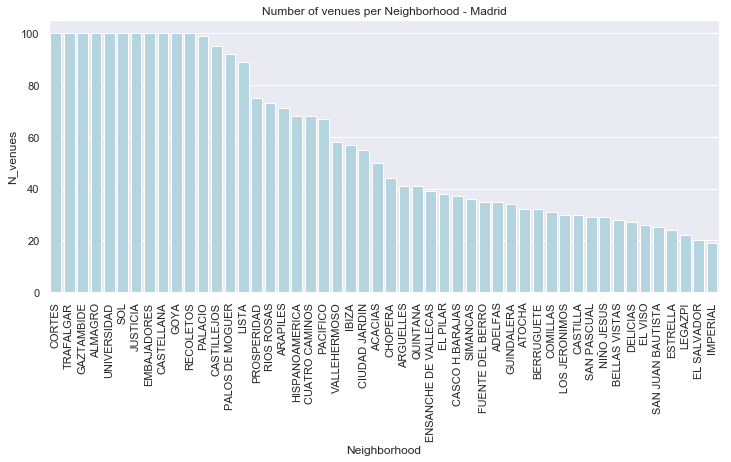

In [638]:
#Plot number of venues registered per neighborhood for Madrid
ax = sns.barplot(x='Neighborhood',y='N_venues',data=venues_count_madrid, color='lightblue')
ax.set_title('Number of venues per Neighborhood - Madrid')
ax.set_xticklabels(labels=venues_count_madrid['Neighborhood'],rotation=90);

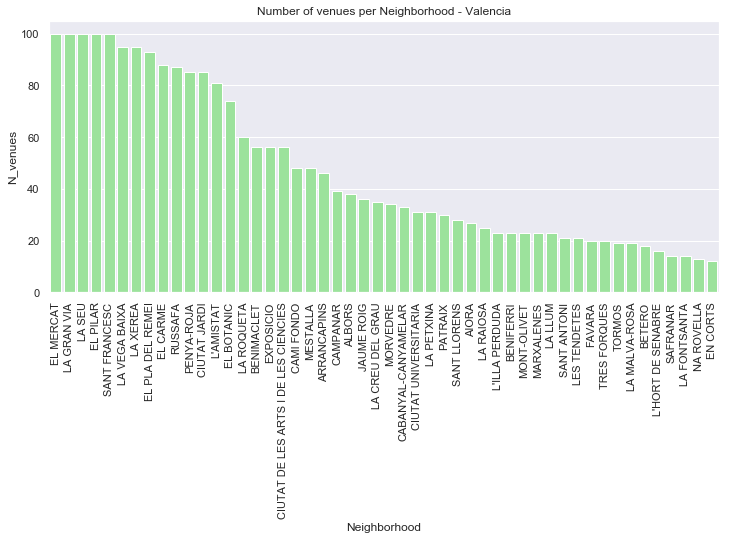

In [639]:
#Plot number of venues registered per Neighborhood for Valencia
ax2 = sns.barplot(x='Neighborhood',y='N_venues',data=venues_count_val, color='lightgreen')
ax2.set_title('Number of venues per Neighborhood - Valencia')
ax2.set_xticklabels(labels=venues_count_val['Neighborhood'],rotation=90);

In [663]:
#Lets explore the venues for one Neighborhood in Madrid
venues[venues['Neighborhood']=='ATOCHA'].head(10)

,Neighborhood,District,City,Neighborhood Latitude,Neighborhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
661,ATOCHA,ARGANZUELA,Madrid,40.399775,-3.681931,La Cevicucheria,40.402679,-3.680336,Peruvian Restaurant
662,ATOCHA,ARGANZUELA,Madrid,40.399775,-3.681931,la esquina de tellez,40.402756,-3.680599,Restaurant
663,ATOCHA,ARGANZUELA,Madrid,40.399775,-3.681931,Candela Pinchos & Drinks,40.402524,-3.679898,Spanish Restaurant
664,ATOCHA,ARGANZUELA,Madrid,40.399775,-3.681931,El Caldero,40.402563,-3.680663,Restaurant
665,ATOCHA,ARGANZUELA,Madrid,40.399775,-3.681931,The Burger Lobby,40.398921,-3.684790,Burger Joint
666,ATOCHA,ARGANZUELA,Madrid,40.399775,-3.681931,Centro Supera 24h,40.403223,-3.679273,Gymnastics Gym
667,ATOCHA,ARGANZUELA,Madrid,40.399775,-3.681931,Chino Sur,40.396189,-3.681183,Chinese Restaurant
668,ATOCHA,ARGANZUELA,Madrid,40.399775,-3.681931,Monte Pinos,40.402653,-3.677546,Café
669,ATOCHA,ARGANZUELA,Madrid,40.399775,-3.681931,Domino's Pizza,40.402188,-3.678252,Pizza Place
670,ATOCHA,ARGANZUELA,Madrid,40.399775,-3.681931,MARIANA Café - Bar & After Work,40.398116,-3.686270,Breakfast Spot


In [641]:
#We can count the number of venues per category as follows
venues[venues['Neighborhood']=='Atocha'].groupby('Venue Category')['Neighborhood'].count().sort_values(ascending=False)

Series([], Name: Neighborhood, dtype: int64)

We can see that the most common category in this neighborhood is "Restaurant", not specifiying the type.  

In order to compare different neighborhoods, we should obtain an indicator that allows us to now the proportion of venues of a specific type. We will do this by performing onehot encoding for each venue of each neighborhood, and then averageing the values as we did in the course's lab.

In [642]:
#One hot encoding
venues_onehot = pd.get_dummies(venues[['Venue Category']], prefix="", prefix_sep="")

In [643]:
venues_onehot.head(3)

,Accessories Store,African Restaurant,Airport,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,Art Museum,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [644]:
# Add the neighborhood column back to the dataframe
venues_onehot['Neighborhood'] = venues['Neighborhood'] 

In [645]:
# Average per neighborhood
venues_grouped = venues_onehot.groupby(['Neighborhood']).mean().reset_index()
venues_grouped.head()

,Neighborhood,Accessories Store,African Restaurant,Airport,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,ABRANTES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACACIAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ADELFAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AEROPUERTO,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AIORA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now we have, for each neighborhood, the distribution of types of venues that exist on a scale from 0 to 1. This will be used later for clustering.  

To end this section, we will create a dataframe with the top 10 most common venue type per neighborhood, this can be used later for analysis

In [646]:
# Borrow the function from the lab. Sort the venues in descending order
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    return row_categories_sorted.index.values[0:num_top_venues]

In [647]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighborhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
neighborhoods_venues_sorted = pd.DataFrame(columns=columns)
neighborhoods_venues_sorted['Neighborhood'] = venues_grouped['Neighborhood']

for ind in np.arange(venues_grouped.shape[0]):
    neighborhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(venues_grouped.iloc[ind, :], num_top_venues)

neighborhoods_venues_sorted.head(10)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,ABRANTES,Bar,Plaza,Fast Food Restaurant,Soccer Field,Pizza Place,Park,Food,Farmers Market,Fish & Chips Shop,Fish Market
1,ACACIAS,Spanish Restaurant,Pizza Place,Supermarket,Bar,Tapas Restaurant,Park,Playground,Indie Theater,Gym,Café
2,ADELFAS,Café,Supermarket,Fast Food Restaurant,Tapas Restaurant,Grocery Store,Bar,Asian Restaurant,Coffee Shop,Tea Room,Museum
3,AEROPUERTO,Accessories Store,Airport Service,Food Truck,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
4,AIORA,Hotel,Bakery,Mediterranean Restaurant,Supermarket,Grocery Store,Café,Latin American Restaurant,Metro Station,Paella Restaurant,Bike Rental / Bike Share
5,ALAMEDA DE OSUNA,Smoke Shop,Restaurant,Fried Chicken Joint,Music School,Spanish Restaurant,Bookstore,Scenic Lookout,Metro Station,Tapas Restaurant,Chinese Restaurant
6,ALBORS,Tapas Restaurant,Mediterranean Restaurant,Restaurant,Gym / Fitness Center,Chinese Restaurant,Nightclub,Movie Theater,Tea Room,Mexican Restaurant,Gastropub
7,ALMAGRO,Spanish Restaurant,Restaurant,Bar,Mediterranean Restaurant,Japanese Restaurant,Plaza,Italian Restaurant,Nightclub,French Restaurant,Hotel
8,ALMENARA,Gym / Fitness Center,Spanish Restaurant,Food & Drink Shop,Martial Arts Dojo,Chinese Restaurant,Flea Market,Library,Supermarket,Food Truck,Football Stadium
9,ALMENDRALES,Spanish Restaurant,Chinese Restaurant,Train Station,Grocery Store,Bar,Bakery,BBQ Joint,Seafood Restaurant,Fast Food Restaurant,Gastropub


In [648]:
#Add the basic neighborhood information
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(neighborhoods, on='Neighborhood')
neighborhoods_venues_sorted.head(3)

,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue,District,Longitude,Latitude,City
0,ABRANTES,Bar,Plaza,Fast Food Restaurant,Soccer Field,Pizza Place,Park,Food,Farmers Market,Fish & Chips Shop,Fish Market,CARABANCHEL,-3.726166,40.378976,Madrid
1,ACACIAS,Spanish Restaurant,Pizza Place,Supermarket,Bar,Tapas Restaurant,Park,Playground,Indie Theater,Gym,Café,ARGANZUELA,-3.707261,40.401068,Madrid
2,ADELFAS,Café,Supermarket,Fast Food Restaurant,Tapas Restaurant,Grocery Store,Bar,Asian Restaurant,Coffee Shop,Tea Room,Museum,RETIRO,-3.670973,40.401116,Madrid


In [649]:
#Reorder columns
columns = ['City','District','Neighborhood','Longitude','Latitude'] + neighborhoods_venues_sorted.columns[1:11].tolist()
columns

['City',
 'District',
 'Neighborhood',
 'Longitude',
 'Latitude',
 '1st Most Common Venue',
 '2nd Most Common Venue',
 '3rd Most Common Venue',
 '4th Most Common Venue',
 '5th Most Common Venue',
 '6th Most Common Venue',
 '7th Most Common Venue',
 '8th Most Common Venue',
 '9th Most Common Venue',
 '10th Most Common Venue']

In [650]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted[columns]
neighborhoods_venues_sorted.head()

,City,District,Neighborhood,Longitude,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Madrid,CARABANCHEL,ABRANTES,-3.726166,40.378976,Bar,Plaza,Fast Food Restaurant,Soccer Field,Pizza Place,Park,Food,Farmers Market,Fish & Chips Shop,Fish Market
1,Madrid,ARGANZUELA,ACACIAS,-3.707261,40.401068,Spanish Restaurant,Pizza Place,Supermarket,Bar,Tapas Restaurant,Park,Playground,Indie Theater,Gym,Café
2,Madrid,RETIRO,ADELFAS,-3.670973,40.401116,Café,Supermarket,Fast Food Restaurant,Tapas Restaurant,Grocery Store,Bar,Asian Restaurant,Coffee Shop,Tea Room,Museum
3,Madrid,BARAJAS,AEROPUERTO,-3.563446,40.478558,Accessories Store,Airport Service,Food Truck,Fast Food Restaurant,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop
4,Valencia,12,AIORA,-0.343360,39.465733,Hotel,Bakery,Mediterranean Restaurant,Supermarket,Grocery Store,Café,Latin American Restaurant,Metro Station,Paella Restaurant,Bike Rental / Bike Share


With the above dataframe we get an idea of the types of venues that can be found on each neighborhood.

### 3.3. Clustering Madrid and Valencia neighborhoods <a id='id-3-3'></a>

Now that we have created a dataframe with features characterizing each neighborhood, based solely on the existing venues, we now proceed to cluster together neighborhoods that have similar characteristics.  

We will be using k-means clustering to achieve this

In [651]:
# Import necessary libraries
import numpy as np 
from sklearn.cluster import KMeans 
import matplotlib.pyplot as plt 
from sklearn import preprocessing
%matplotlib inline

In the previous section, we created the dataframe shown below. The features of the dataframe correspond to the rate of venues of each type within the neighborhood

In [652]:
venues_grouped.head()

,Neighborhood,Accessories Store,African Restaurant,Airport,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,ABRANTES,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,ACACIAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,ADELFAS,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,AEROPUERTO,0.5,0.0,0.0,0.5,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,AIORA,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


Now lets initialize the k-means model using K=20

In [653]:
k_means = KMeans(init = "k-means++", n_clusters = 20, n_init = 15)

In [654]:
# Fit the model 
k_means.fit(venues_grouped.drop('Neighborhood',axis=1))

KMeans(algorithm='auto', copy_x=True, init='k-means++', max_iter=300,
    n_clusters=20, n_init=15, n_jobs=None, precompute_distances='auto',
    random_state=None, tol=0.0001, verbose=0)

In [655]:
#Add the labels to the venues_grouped dataset
venues_grouped['Cluster']=k_means.labels_

In [656]:
#Obtain the number of neighborhoods per cluster
venues_grouped.groupby('Cluster')['Neighborhood'].count()

Cluster
0      1
1     32
2     77
3      1
4     54
5      1
6      1
7      2
8      1
9      1
10     6
11     2
12     1
13     1
14     1
15     1
16     1
17    22
18     1
19     2
Name: Neighborhood, dtype: int64

In [657]:
neighborhoods_venues_sorted = neighborhoods_venues_sorted.merge(venues_grouped, on='Neighborhood')

In [658]:
neighborhoods_venues_sorted.head()

,City,District,Neighborhood,Longitude,Latitude,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,...,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio,Cluster
0,Madrid,CARABANCHEL,ABRANTES,-3.726166,40.378976,Bar,Plaza,Fast Food Restaurant,Soccer Field,Pizza Place,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
1,Madrid,ARGANZUELA,ACACIAS,-3.707261,40.401068,Spanish Restaurant,Pizza Place,Supermarket,Bar,Tapas Restaurant,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4
2,Madrid,RETIRO,ADELFAS,-3.670973,40.401116,Café,Supermarket,Fast Food Restaurant,Tapas Restaurant,Grocery Store,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,Madrid,BARAJAS,AEROPUERTO,-3.563446,40.478558,Accessories Store,Airport Service,Food Truck,Fast Food Restaurant,Fish & Chips Shop,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
4,Valencia,12,AIORA,-0.343360,39.465733,Hotel,Bakery,Mediterranean Restaurant,Supermarket,Grocery Store,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2


Now, our customer wishes to open the restaurant in a neighborhood similar to **El Carme**. Lets check on which cluster does that neighborhood belong to

In [659]:
target_cluster_df = neighborhoods_venues_sorted.loc[neighborhoods_venues_sorted['Neighborhood']=='EL CARME']
target_cluster_df.reset_index(inplace=True)
target_cluster=target_cluster_df.loc[0].at['Cluster']
print('The target cluster is: {} '.format(target_cluster))

The target cluster is: 2 


In [739]:
#Filter neighborhoods from Madrid that belong to the target cluster
possible_neighborhoods = neighborhoods_venues_sorted[
    (neighborhoods_venues_sorted['Cluster']==target_cluster) &
    (neighborhoods_venues_sorted['City']=='Madrid')]

print('There are {} neighborhoods in Madrid with similar characteristics than El Carme'
      .format(possible_neighborhoods.shape[0]))

There are 38 neighborhoods in Madrid with similar characteristics than El Carme


In [740]:
# Clean up index
possible_neighborhoods.reset_index(inplace=True, drop=True)

The dataset below contains the possible locations for the new restaurant. These have similar characteristics than the El Carme neighborhood in Valencia.  
In the following section, we will rank each neighborhood and provide our customer with the top 10 recommendations.

In [742]:
# Print the possible neighborhoods
possible_neighborhoods = possible_neighborhoods[['District','Neighborhood','1st Most Common Venue','2nd Most Common Venue','3rd Most Common Venue']]
possible_neighborhoods

,District,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue
0,RETIRO,ADELFAS,Café,Supermarket,Fast Food Restaurant
1,BARAJAS,ALAMEDA DE OSUNA,Smoke Shop,Restaurant,Fried Chicken Joint
2,CHAMBERÍ,ALMAGRO,Spanish Restaurant,Restaurant,Bar
3,SAN BLAS - CANILLEJAS,ARCOS,Restaurant,Multiplex,Optical Shop
4,ARGANZUELA,ATOCHA,Restaurant,Grocery Store,Tapas Restaurant
5,TETUÁN,BERRUGUETE,Tapas Restaurant,Bar,Spanish Restaurant
6,BARAJAS,CASCO H.BARAJAS,Hotel,Spanish Restaurant,Gastropub
7,CHAMARTÍN,CASTILLA,Platform,Café,Hotel
8,ARGANZUELA,CHOPERA,Park,Plaza,Spanish Restaurant
9,CHAMARTÍN,CIUDAD JARDIN,Café,Tapas Restaurant,Spanish Restaurant


After the clustering process, we find a rather large number of neighborhoods that are similar to our target. In the next section, we will select the top 10 candidates based on additional criteria.

### 3.4. Neighborhood Ranking <a id='id-3-4'></a>

We now have a dataset containing a list of potential neighborhoods. Our task now is to select the top 10 in order to present our findings to the customer.  

We will rank each neighborhood based on a composite ranking using the following items:  

a. Total Population. *Weight: 50%*  
b. Average income per household within each neighborhood. *Weight: 25%*  
c. Amount of already existing Italian restaurants. *Weight: 25%* 

To create this ranking, lets first normalize each of the three metrics

In [694]:
#Population dataset
madrid_population.head(3)

,District,Neighborhood,Population
0,CENTRO,PALACIO,22984
1,CENTRO,EMBAJADORES,45433
2,CENTRO,CORTES,10525


In [706]:
madrid_population['Population_Normalized'] = madrid_population['Population']/madrid_population['Population'].max(axis=0)
madrid_population.head(3)

,District,Neighborhood,Population,Rate_to_Total,Population_Normalized
0,CENTRO,PALACIO,22984,0.007018,0.345406
1,CENTRO,EMBAJADORES,45433,0.013872,0.682772
2,CENTRO,CORTES,10525,0.003214,0.158171


In [705]:
madrid_income['Income_Normalized'] = madrid_income['Average Income']/madrid_income['Average Income'].max(axis=0)
madrid_income.head(3)

,District,Neighborhood,Average Income,Income_Normalized
0,CENTRO,PALACIO,34675.85,0.308722
1,CENTRO,EMBAJADORES,25999.83,0.231478
2,CENTRO,CORTES,34952.68,0.311186


In [709]:
venues_grouped.columns

Index(['Neighborhood', 'Accessories Store', 'African Restaurant', 'Airport',
       'Airport Service', 'American Restaurant', 'Arcade', 'Arepa Restaurant',
       'Argentinian Restaurant', 'Art Gallery',
       ...
       'Vegetarian / Vegan Restaurant', 'Video Game Store', 'Video Store',
       'Vietnamese Restaurant', 'Warehouse Store', 'Whisky Bar', 'Wine Bar',
       'Wine Shop', 'Yoga Studio', 'Cluster'],
      dtype='object', length=296)

In [732]:
#Based on section 3.2 
madrid_italian = venues_onehot.groupby(['Neighborhood']).sum().reset_index()
madrid_italian.head()

,Neighborhood,Accessories Store,African Restaurant,Airport,Airport Service,American Restaurant,Arcade,Arepa Restaurant,Argentinian Restaurant,Art Gallery,...,Used Bookstore,Vegetarian / Vegan Restaurant,Video Game Store,Video Store,Vietnamese Restaurant,Warehouse Store,Whisky Bar,Wine Bar,Wine Shop,Yoga Studio
0,ABRANTES,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,ACACIAS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,ADELFAS,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,AEROPUERTO,1,0,0,1,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,AIORA,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [733]:
madrid_italian = madrid_italian[['Neighborhood','Italian Restaurant']]
madrid_italian.rename(columns={"Italian Restaurant": "Number_Italian_Restaurants"}, inplace=True)
madrid_italian.head()

,Neighborhood,Number_Italian_Restaurants
0,ABRANTES,0
1,ACACIAS,1
2,ADELFAS,0
3,AEROPUERTO,0
4,AIORA,0


In [734]:
#"Normalize" and invert. This way, if a row is 1 then it means there are no italian restaurants
madrid_italian['Non_Italian_Restaurants'] = 1-madrid_italian['Number_Italian_Restaurants']/madrid_italian['Number_Italian_Restaurants'].max(axis=0)
madrid_italian.head(10)

,Neighborhood,Number_Italian_Restaurants,Non_Italian_Restaurants
0,ABRANTES,0,1.000000
1,ACACIAS,1,0.888889
2,ADELFAS,0,1.000000
3,AEROPUERTO,0,1.000000
4,AIORA,0,1.000000
5,ALAMEDA DE OSUNA,0,1.000000
6,ALBORS,0,1.000000
7,ALMAGRO,4,0.555556
8,ALMENARA,0,1.000000
9,ALMENDRALES,0,1.000000


Now we put together the three datasets and create the ranking

In [745]:
possible_neighborhoods = possible_neighborhoods.merge(madrid_population[['Neighborhood','Population','Population_Normalized']], on='Neighborhood')
possible_neighborhoods = possible_neighborhoods.merge(madrid_income[['Neighborhood','Income_Normalized']], on='Neighborhood')
possible_neighborhoods = possible_neighborhoods.merge(madrid_italian[['Neighborhood','Non_Italian_Restaurants']], on='Neighborhood')

In [746]:
possible_neighborhoods.head(3)

,District,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Population,Population_Normalized,Income_Normalized,Non_Italian_Restaurants
0,RETIRO,ADELFAS,Café,Supermarket,Fast Food Restaurant,18516,0.278260,0.408143,1.000000
1,BARAJAS,ALAMEDA DE OSUNA,Smoke Shop,Restaurant,Fried Chicken Joint,19573,0.294145,0.465463,1.000000
2,CHAMBERÍ,ALMAGRO,Spanish Restaurant,Restaurant,Bar,19858,0.298428,0.612413,0.555556


In [778]:
possible_neighborhoods['Ranking'] = possible_neighborhoods['Population_Normalized'] * 0.5 + possible_neighborhoods['Income_Normalized'] * 0.35 + possible_neighborhoods['Non_Italian_Restaurants'] * 0.1
recommended_neighborhoods = possible_neighborhoods.sort_values(by='Ranking',ascending=False).head(10)
recommended_neighborhoods.reset_index(inplace=True, drop=True)

## 4. Results Summary<a id='results'></a>


After performing a clustering analysis a group of 59 possible neighborhoods was identified with similar characteristics to the target neighborhood from Valencia.

In [777]:
possible_neighborhoods

,District,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Population,Population_Normalized,Income_Normalized,Non_Italian_Restaurants,Ranking
0,RETIRO,ADELFAS,Café,Supermarket,Fast Food Restaurant,18516,0.278260,0.408143,1.000000,0.381980
1,BARAJAS,ALAMEDA DE OSUNA,Smoke Shop,Restaurant,Fried Chicken Joint,19573,0.294145,0.465463,1.000000,0.409985
2,CHAMBERÍ,ALMAGRO,Spanish Restaurant,Restaurant,Bar,19858,0.298428,0.612413,0.555556,0.419114
3,SAN BLAS - CANILLEJAS,ARCOS,Restaurant,Multiplex,Optical Shop,24298,0.365153,0.250277,1.000000,0.370174
4,ARGANZUELA,ATOCHA,Restaurant,Grocery Store,Tapas Restaurant,1176,0.017673,0.337776,0.888889,0.215947
5,TETUÁN,BERRUGUETE,Tapas Restaurant,Bar,Spanish Restaurant,25089,0.377040,0.257704,1.000000,0.378717
6,BARAJAS,CASCO H.BARAJAS,Hotel,Spanish Restaurant,Gastropub,7585,0.113988,0.262196,1.000000,0.248763
7,CHAMARTÍN,CASTILLA,Platform,Café,Hotel,16953,0.254771,0.488511,1.000000,0.398365
8,ARGANZUELA,CHOPERA,Park,Plaza,Spanish Restaurant,20048,0.301283,0.284310,0.888889,0.339039
9,CHAMARTÍN,CIUDAD JARDIN,Café,Tapas Restaurant,Spanish Restaurant,18689,0.280860,0.389126,1.000000,0.376624


For the clustering process we picket a large number of cluster (K=20), nevertheless most of the neighborhoods fell into 5 clusters, as shown below

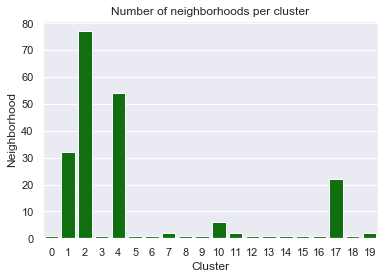

In [780]:
venues_grouped_count = venues_grouped.groupby('Cluster')['Neighborhood'].count().to_frame()
venues_grouped_count.reset_index(inplace=True)
ax = sns.barplot(x='Cluster', y='Neighborhood', data=venues_grouped_count, color='green')
ax.set_title('Number of neighborhoods per cluster');

The amount of neighborhoods obtained from the clustering analysis was still high, so I decided to order the data based on additional criteria, such as neihgborhood population, average income and the competition. Finally, we came out with a list of 10 potential target neighborhoods

In [781]:
recommended_neighborhoods

,District,Neighborhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,Population,Population_Normalized,Income_Normalized,Non_Italian_Restaurants,Ranking
0,SALAMANCA,GUINDALERA,Spanish Restaurant,Japanese Restaurant,Grocery Store,41751,0.627438,0.412576,1.000000,0.558121
1,CHAMARTÍN,NUEVA ESPAÑA,Restaurant,Tapas Restaurant,Mediterranean Restaurant,24699,0.371179,0.714457,1.000000,0.535650
2,VILLA DE VALLECAS,ENSANCHE DE VALLECAS,Clothing Store,Fast Food Restaurant,Spanish Restaurant,45895,0.689715,0.322067,0.777778,0.535358
3,CARABANCHEL,VISTA ALEGRE,Pizza Place,Cosmetics Shop,Athletics & Sports,46122,0.693126,0.247401,1.000000,0.533153
4,CENTRO,EMBAJADORES,Bar,Café,Tapas Restaurant,45433,0.682772,0.231478,1.000000,0.522403
5,CHAMARTÍN,PROSPERIDAD,Bar,Spanish Restaurant,Café,36730,0.551982,0.389078,0.888889,0.501057
6,FUENCARRAL - EL PARDO,EL PILAR,Tapas Restaurant,Spanish Restaurant,Italian Restaurant,46577,0.699964,0.300443,0.000000,0.455137
7,CHAMBERÍ,VALLEHERMOSO,Restaurant,Bar,Spanish Restaurant,20297,0.305025,0.529364,1.000000,0.437790
8,CARABANCHEL,OPAÑEL,Bar,Coffee Shop,Fast Food Restaurant,33145,0.498106,0.249566,1.000000,0.436401
9,SALAMANCA,RECOLETOS,Restaurant,Spanish Restaurant,Hotel,15786,0.237234,0.754141,0.444444,0.427011


The selected neighborhoods have similar characteristics than the source neighborhood from Valencia city. 